In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics
from pprint import pprint

from src.models import InvariantsICNN
from src.data_import import load_paml_dataset, load_data
from src.plots import plot_predictions, plot_loss, plot_heatmap
from src.utils import get_scores

2024-11-20 14:59:29.226196: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 14:59:29.230101: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 14:59:29.241239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 14:59:29.260151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 14:59:29.265627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 14:59:29.279496: I tensorflow/core/platform/cpu_feature_gu

## Paths

In [2]:
# Calibration paths
calibration_dir = os.path.abspath('calibration')
biaxial_path = os.path.join(calibration_dir, 'biaxial.txt')
pure_shear_path = os.path.join(calibration_dir, 'pure_shear.txt')
uniaxial_path = os.path.join(calibration_dir, 'uniaxial.txt')

# Test paths
test_dir = os.path.abspath('test')
biax_test_path = os.path.join(test_dir, 'biax_test.txt')
mixed_test_path = os.path.join(test_dir, 'mixed_test.txt')

## Load Datasets

In [3]:
biaxial_features, biaxial_labels, _ = load_data(biaxial_path)
pure_shear_features, pure_shear_labels, _ = load_data(pure_shear_path)
uniaxial_features, uniaxial_labels, _ = load_data(uniaxial_path)

biax_test_features, biax_test_labels, _ = load_data(biax_test_path)
mixed_test_features, mixed_test_labels, _ = load_data(mixed_test_path)

# Task 2.3 - Physics-augmented neural network model

## Model Initialization and Training

In [4]:
train_features = tf.concat([biaxial_features, pure_shear_features, uniaxial_features], axis=0)
train_labels = tf.concat([biaxial_labels, pure_shear_labels, uniaxial_labels], axis=0)

In [5]:
naive_model = InvariantsICNN(
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.002),
    loss=losses.MeanSquaredError()
)
h = naive_model.fit(train_features, train_labels, batch_size=32, epochs=15000, verbose=0)
loss = h.history['loss']

/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


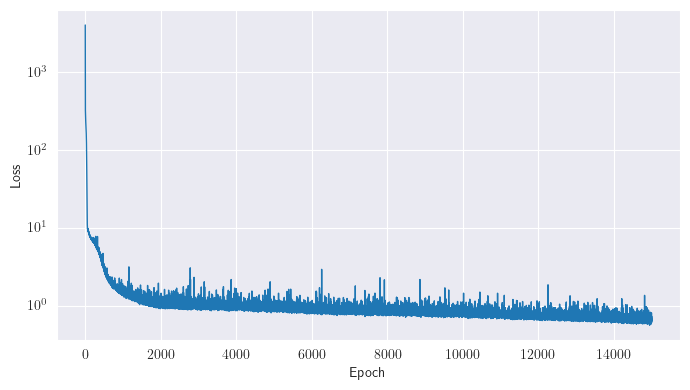

In [6]:
fig = plot_loss(loss)
fig.tight_layout()
plt.show()

### Model Evaluation

#### -- on seen load cases

In [7]:
biaxial_predictions = naive_model.predict(biaxial_features)
pure_shear_predictions = naive_model.predict(pure_shear_features)
uniaxial_predictions = naive_model.predict(uniaxial_features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


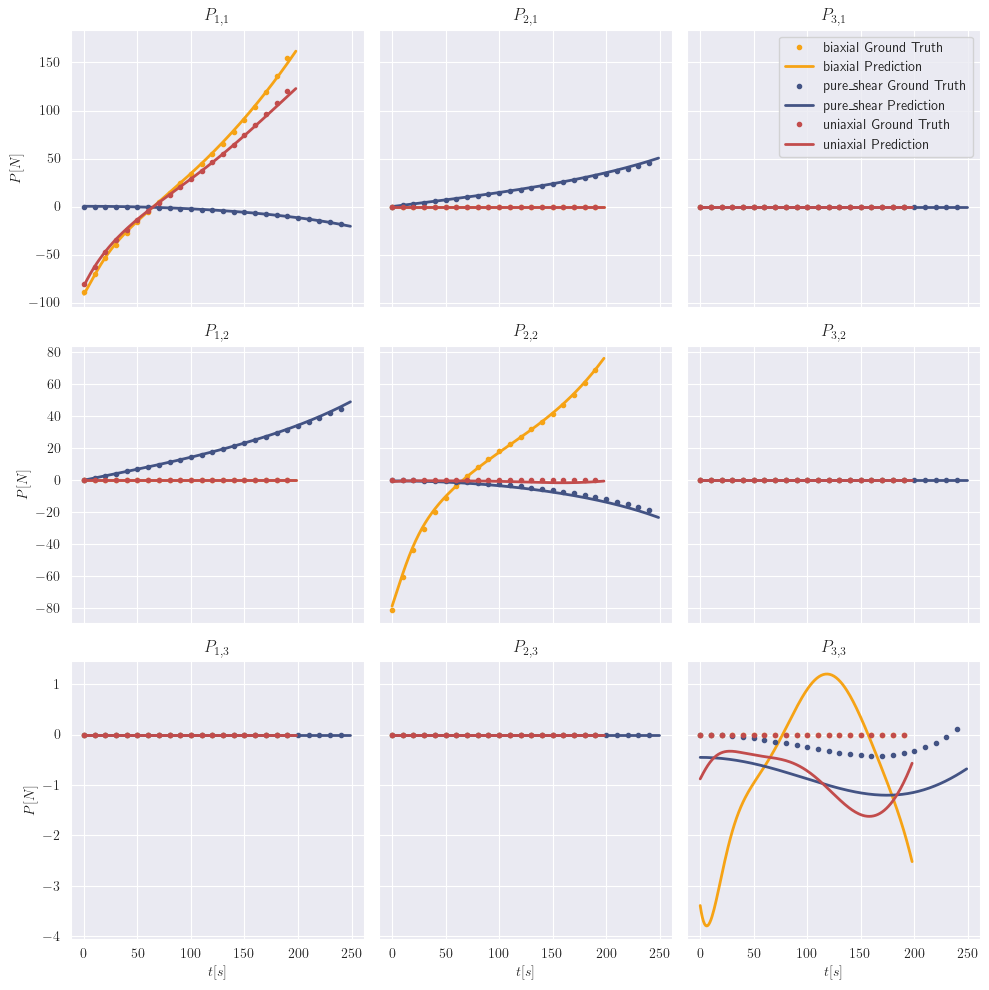

In [8]:
labels = {
    'biaxial': biaxial_labels.numpy().reshape((-1, 9)),
    'pure_shear': pure_shear_labels.numpy().reshape((-1, 9)),
    'uniaxial': uniaxial_labels.numpy().reshape((-1, 9)),
}
predictions = {
    'biaxial': biaxial_predictions.reshape((-1, 9)),
    'pure_shear': pure_shear_predictions.reshape((-1, 9)),
    'uniaxial': uniaxial_predictions.reshape((-1, 9)),
}
fig_train_pred = plot_predictions(labels, predictions)
fig_train_pred.tight_layout()
plt.show()

#### -- on unseen load cases

In [9]:
biax_test_preds = naive_model.predict(biax_test_features)
mixed_test_preds = naive_model.predict(mixed_test_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


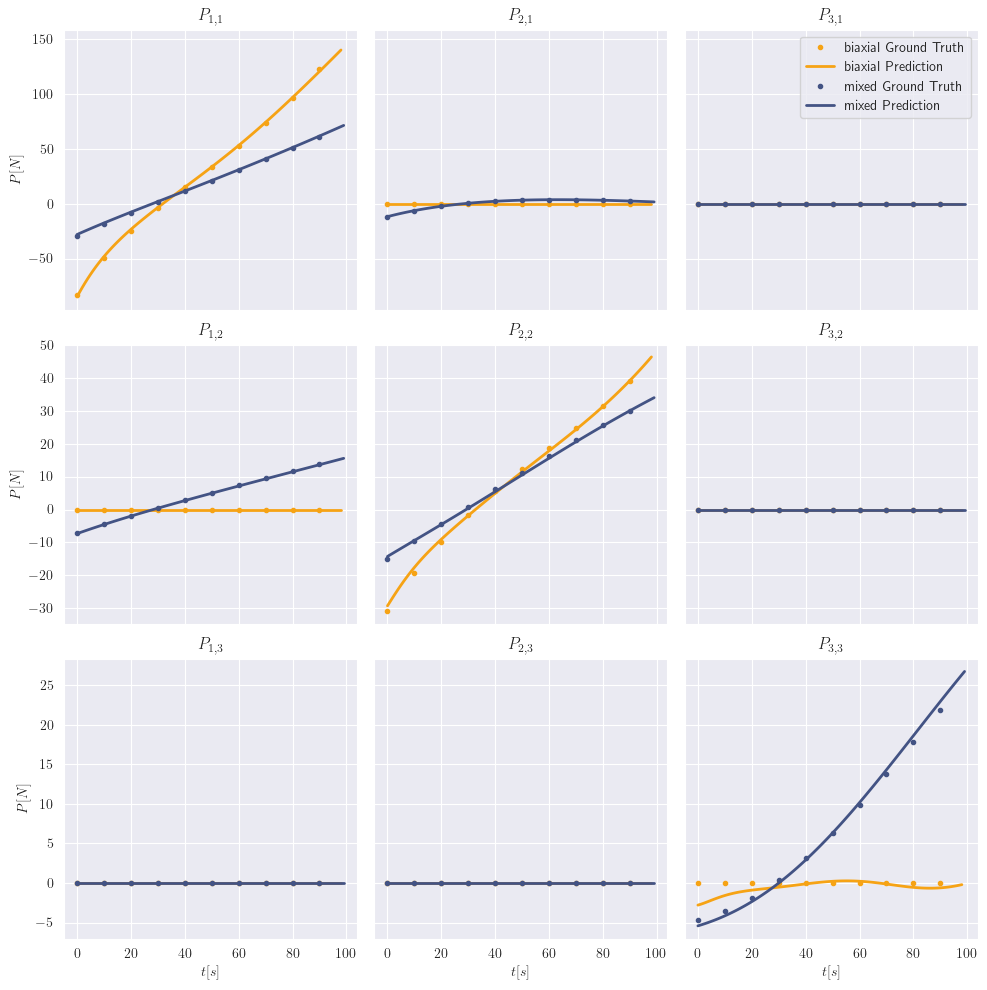

In [10]:
test_labels = {
    'biaxial': biax_test_labels.numpy().reshape((-1, 9)),
    'mixed': mixed_test_labels.numpy().reshape((-1, 9)),
}
test_predictions = {
    'biaxial': biax_test_preds.reshape((-1, 9)),
    'mixed': mixed_test_preds.reshape((-1, 9)),
}
fig_test_pred = plot_predictions(test_labels, test_predictions)
fig_test_pred.tight_layout()
plt.show()

## Get scores

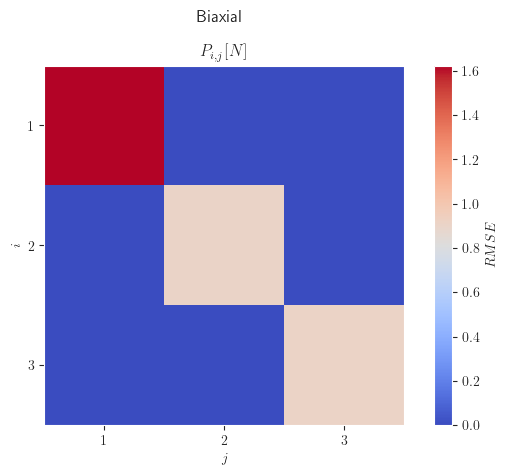

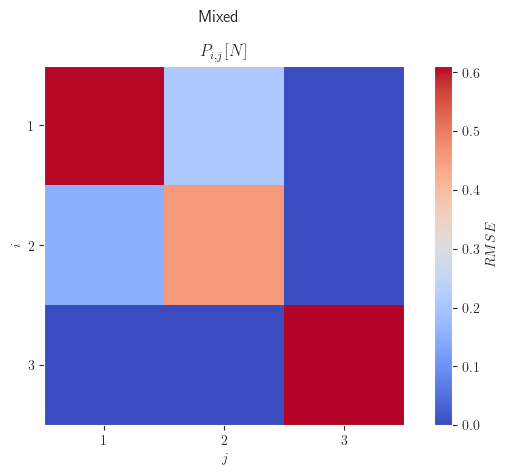

In [11]:
scores = get_scores(test_labels, test_predictions, type='rmse')
for name, values in scores.items():
    fig_heat = plot_heatmap(values, vmin=None, vmax=None, title=name.capitalize(), cbar_label='$RMSE$')
    fig_heat.tight_layout()
    plt.show()